In [1]:
import torchvision

C:\Users\add\AppData\Local\Temp\ipykernel_24780\4068962148.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


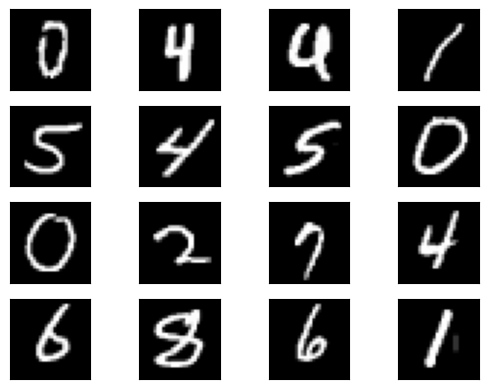